# Station Exploration

* !!! Warning: NA values in station elevation have to be correctly set !!!
* Use GHCN daily data ?
* Work only with data after 1979 (ERA-int period)

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date
import pandas as pd
from sklearn.decomposition import PCA
import sklearn.linear_model as skl_lm
import gdal as gdl
import matplotlib.mlab as ml
import cartopy.crs as ccrs
import plotly.graph_objs as go
import plotly.offline as py
import sklearn.linear_model as skl_lm
from functools import reduce

py.init_notebook_mode(connected=True) # for live plot
pd.set_option('display.notebook_repr_html', False)
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)
db = mg.GHCN
db.collection_names()

['data', 'system.indexes', 'stations']

In [3]:
# Find Swiss stations
sta_df = pd.DataFrame(list(db.stations.find(filter={'country': 'SWITZERLAND'})))
sta_df

                         _id      country  country_id    elev  \
0   5abe7d8823c8cceb0c3f9563  SWITZERLAND         646   491.0   
1   5abe7d8823c8cceb0c3f9565  SWITZERLAND         646  -999.0   
2   5abe7d8823c8cceb0c3f9567  SWITZERLAND         646   318.0   
3   5abe7d8823c8cceb0c3f9569  SWITZERLAND         646   569.0   
4   5abe7d8823c8cceb0c3f956b  SWITZERLAND         646  2500.0   
5   5abe7d8823c8cceb0c3f956d  SWITZERLAND         646   416.0   
6   5abe7d8823c8cceb0c3f956f  SWITZERLAND         646   405.0   
7   5abe7d8823c8cceb0c3f9571  SWITZERLAND         646  2460.0   
8   5abe7d8823c8cceb0c3f9573  SWITZERLAND         646  3576.0   
9   5abe7d8823c8cceb0c3f9575  SWITZERLAND         646  2095.0   
10  5abe7d8823c8cceb0c3f9577  SWITZERLAND         646   276.0   

          landcover                                              loc  \
0   WARM FOR./FIELD  {'type': 'Point', 'coordinates': [6.95, 46.82]}   
1        WARM CROPS    {'type': 'Point', 'coordinates': [7.4, 47.0]}   
2  

In [4]:
sta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 10 columns):
_id           11 non-null object
country       11 non-null object
country_id    11 non-null int64
elev          11 non-null float64
landcover     11 non-null object
loc           11 non-null object
name          11 non-null object
popclass      11 non-null object
station_id    11 non-null int64
wmo_id        11 non-null int64
dtypes: float64(1), int64(3), object(6)
memory usage: 960.0+ bytes


In [5]:
# Query Temperature data
# Zurich has the station_id = 64606660000
this_id = 64606660000
dat_df = pd.DataFrame(list(db.data.find(filter={'station_id': this_id}))).\
pipe(lambda df: df[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'year']]).\
pipe(lambda df: df.query('year >= 1979'))
dat_df.head()

       1    2    3    4     5     6     7     8     9   10   11   12  year
128 -2.9  2.0  5.1  6.1  12.4  16.1  17.2  15.6  13.8  9.7  3.7  3.8  1979
129 -1.2  3.3  4.8  5.9  10.8  14.0  15.0  17.8  14.9  8.3  2.9 -0.5  1980
130 -2.1 -1.1  7.4  9.5  12.1  15.6  16.3  17.6  14.0  9.2  4.6  0.5  1981
131  0.2  0.7  4.0  7.3  12.9  16.7  19.0  16.6  15.9  9.2  5.9  2.7  1982
132  2.9 -1.6  5.5  9.1  10.6  16.9  22.0  18.1  14.4  9.7  3.0  1.0  1983

In [6]:
# Create DF for winter month
w_df = dat_df[['year', '1', '2', '12']]
w_df.head()

     year    1    2   12
128  1979 -2.9  2.0  3.8
129  1980 -1.2  3.3 -0.5
130  1981 -2.1 -1.1  0.5
131  1982  0.2  0.7  2.7
132  1983  2.9 -1.6  1.0

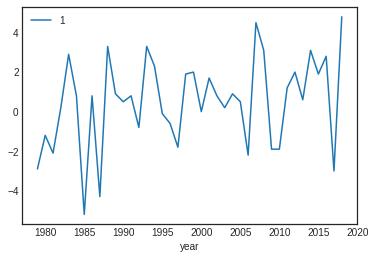

In [7]:
# Quick check with January
w_df.plot(x='year', y='1')

In [8]:
# Reformat data
dec_df = w_df[['year', '12']]
dec_df = dec_df.assign(wyear=dec_df.year+1).pipe(lambda df: df[['wyear', '12']])
dec_df.head()

     wyear   12
128   1980  3.8
129   1981 -0.5
130   1982  0.5
131   1983  2.7
132   1984  1.0

In [9]:
# Reformat data
jf_df = w_df[['year', '1', '2']].pipe(lambda df: df.rename(columns={'year':'wyear'}))
jf_df.head()

     wyear    1    2
128   1979 -2.9  2.0
129   1980 -1.2  3.3
130   1981 -2.1 -1.1
131   1982  0.2  0.7
132   1983  2.9 -1.6

In [10]:
winter_df = pd.merge(dec_df, jf_df, on='wyear')
winter_df.head()

   wyear   12    1    2
0   1980  3.8 -1.2  3.3
1   1981 -0.5 -2.1 -1.1
2   1982  0.5  0.2  0.7
3   1983  2.7  2.9 -1.6
4   1984  1.0  0.8 -0.6

In [11]:
# compare with
w_df.head()

     year    1    2   12
128  1979 -2.9  2.0  3.8
129  1980 -1.2  3.3 -0.5
130  1981 -2.1 -1.1  0.5
131  1982  0.2  0.7  2.7
132  1983  2.9 -1.6  1.0

In [12]:
# Do the aggregation for december-february risk period
risk_df = winter_df.assign(ave = 0.5*(winter_df[['12']].values +winter_df[['1']].values )).\
pipe(lambda df: df[['wyear', 'ave']])
risk_df.head()

   wyear   ave
0   1980  1.30
1   1981 -1.30
2   1982  0.35
3   1983  2.80
4   1984  0.90

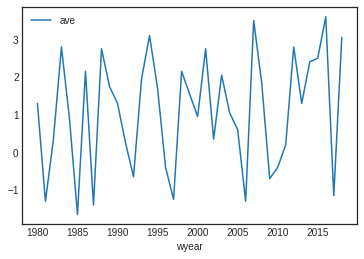

In [13]:
# Quick plot
risk_df.plot(x='wyear', y='ave')

## Query function

Create a function that return the risk_df above as function of:
* station id
* any groupement of dec, jan, feb


In [14]:
def queryData(station_id, mon):
    dat_df = pd.DataFrame(list(db.data.find(filter={'station_id': station_id}))).\
    pipe(lambda df: df[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'year']]).\
    pipe(lambda df: df.query('year >= 1979'))
    w_df = dat_df[['year', '1', '2', '12']]
    # Reformat data
    dec_df = w_df[['year', '12']]
    dec_df = dec_df.assign(wyear=dec_df.year+1).pipe(lambda df: df[['wyear', '12']])
    jf_df = w_df[['year', '1', '2']].pipe(lambda df: df.rename(columns={'year':'wyear'}))
    winter_df = pd.merge(dec_df, jf_df, on='wyear')
    # Do the aggregation for december-february risk period
    risk_df = winter_df
    risk_df['ave'] = risk_df[mon].apply(func=np.mean, axis=1)
    risk_df = risk_df[['wyear', 'ave']].pipe(lambda df: df.rename(columns={'ave': station_id}))
    return(risk_df)

res_df = queryData(station_id=64606660000, mon=['12','1'])
res_df.head()

   wyear  64606660000
0   1980         1.30
1   1981        -1.30
2   1982         0.35
3   1983         2.80
4   1984         0.90

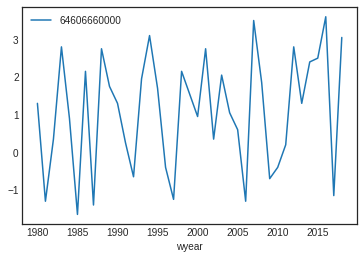

In [15]:
res_df.plot(x='wyear')

In [16]:
ids = sta_df.station_id#[:5]
all_df00 = list(map(lambda x: queryData(station_id=x, mon=['12','1']), ids))

In [17]:
from functools import reduce
all_df = reduce(lambda x,y: pd.merge(x,y,on='wyear', how='outer'), all_df00).\
pipe(lambda df: df.sort_values('wyear', ascending=True)).\
reset_index(drop=True).\
pipe(lambda df: df.dropna(axis=1, thresh=20) ) # NA: at least 20 data obs should be non-NA
all_df.head()

   wyear  64606610000  64606660000  64606680000  64606700000  64606770000
0   1980          1.2         1.30        -7.15         2.60         3.45
1   1981         -1.5        -1.30        -9.50         0.05         3.05
2   1982          NaN         0.35        -8.00          NaN         3.20
3   1983          NaN         2.80        -6.10          NaN         4.90
4   1984          NaN         0.90        -7.45         2.00         3.35

In [18]:
# Rename columns with station names
idf = all_df.drop(columns='wyear').columns
nam_df = sta_df.query('station_id in @idf').pipe(lambda df: df[['station_id', 'name']])
newnames = dict(nam_df.to_dict('split')['data'])
all_df = all_df.rename(columns=newnames)
all_df.tail()

    wyear  PAYERNE  ZURICH (TOWN/  SAENTIS  GENEVE-COINTR  LUGANO
34   2014     1.65           2.40    -4.45           2.80    5.05
35   2015     2.60           2.50    -6.65           3.45    6.00
36   2016     2.95           3.60    -3.70           4.05    5.15
37   2017    -1.50          -1.15    -5.90           0.10    3.90
38   2018     3.20           3.05    -6.50           4.25    4.45

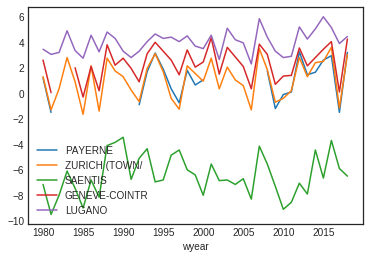

In [19]:
all_df.plot(x='wyear')

In [20]:
# Generic function
def getStationAgg(station_ids, mon):
    all_df00 = list(map(lambda x: queryData(station_id=x, mon=mon), ids))
    all_df = reduce(lambda x,y: pd.merge(x,y,on='wyear', how='outer'), all_df00).\
    pipe(lambda df: df.sort_values('wyear', ascending=True)).\
    reset_index(drop=True).\
    pipe(lambda df: df.dropna(axis=1, thresh=20) ) # NA: at least 20 data obs should be non-NA
    return(all_df)

all_df0 = getStationAgg(station_ids=sta_df.station_id, mon=['12','1'])
all_df0.head()

   wyear  64606610000  64606660000  64606680000  64606700000  64606770000
0   1980          1.2         1.30        -7.15         2.60         3.45
1   1981         -1.5        -1.30        -9.50         0.05         3.05
2   1982          NaN         0.35        -8.00          NaN         3.20
3   1983          NaN         2.80        -6.10          NaN         4.90
4   1984          NaN         0.90        -7.45         2.00         3.35

In [23]:
# Generic rename function
def station_id_to_name(all_df0):
    idf = all_df0.drop(columns='wyear').columns
    sta_df0 = pd.DataFrame(list(db.stations.find(filter={'station_id': {"$in": list(idf)}})))

    nam_df = sta_df0.query('station_id in @idf').pipe(lambda df: df[['station_id', 'name']])
    newnames = dict(nam_df.to_dict('split')['data'])
    all_df = all_df0.rename(columns=newnames)
    return(all_df)

all_df = station_id_to_name(all_df0=all_df0)
all_df.head()

   wyear  PAYERNE  ZURICH (TOWN/  SAENTIS  GENEVE-COINTR  LUGANO
0   1980      1.2           1.30    -7.15           2.60    3.45
1   1981     -1.5          -1.30    -9.50           0.05    3.05
2   1982      NaN           0.35    -8.00            NaN    3.20
3   1983      NaN           2.80    -6.10            NaN    4.90
4   1984      NaN           0.90    -7.45           2.00    3.35

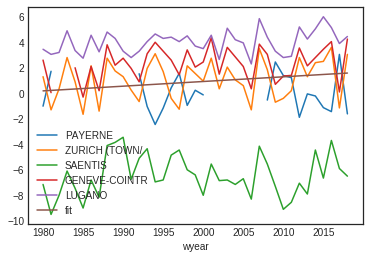

In [38]:
all_df.plot(x='wyear')

# Station Anomalies

For the moment, let's keep it simple: we predict the anomalies from long-term trend.

As a side note for later, check SwissRe guidelines:

* P. 47: *"If the trend in the weather index data is against SRCSGMI, apply detrending on calculated weather index values"*

* i.e., the index itself is detrended, not the original observations!


* p.49: For HDD call and put options, *NO* detrending is applied. The historical period is (!!) the last 10 years period.

This means, we can take advantage of the global temperature trend and use the year index as predictor later.

In [25]:
all_df.head()

   wyear  PAYERNE  ZURICH (TOWN/  SAENTIS  GENEVE-COINTR  LUGANO
0   1980      1.2           1.30    -7.15           2.60    3.45
1   1981     -1.5          -1.30    -9.50           0.05    3.05
2   1982      NaN           0.35    -8.00            NaN    3.20
3   1983      NaN           2.80    -6.10            NaN    4.90
4   1984      NaN           0.90    -7.45           2.00    3.35

### Let's apply detrending to a single station

In [29]:
import sklearn.linear_model as skl_lm
model = skl_lm.LinearRegression()
this_name = 'ZURICH (TOWN/'
# Covariate is the year index
reg_df = all_df[['wyear', this_name]]
X = reg_df.wyear.values.reshape(-1, 1)
y = reg_df[[this_name]]
model.fit(X, y)
lm_pred = model.predict(X)
reg_df['fit'] = lm_pred
reg_df['resid'] = reg_df[this_name]-reg_df.fit
reg_df.head()

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



   wyear  ZURICH (TOWN/       fit     resid
0   1980           1.30  0.568462  0.731538
1   1981          -1.30  0.596235 -1.896235
2   1982           0.35  0.624008 -0.274008
3   1983           2.80  0.651781  2.148219
4   1984           0.90  0.679555  0.220445

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



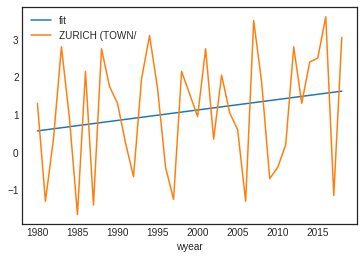

In [30]:
reg_df.plot(x='wyear', y=['fit', this_name])

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



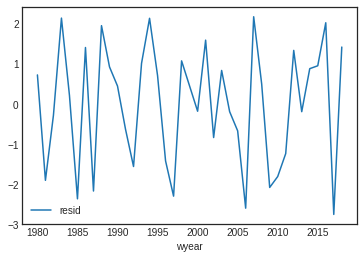

In [31]:
reg_df.plot(x='wyear', y=['resid'])

In [27]:
all_df.head()

   wyear  PAYERNE  ZURICH (TOWN/  SAENTIS  GENEVE-COINTR  LUGANO
0   1980      1.2           1.30    -7.15           2.60    3.45
1   1981     -1.5          -1.30    -9.50           0.05    3.05
2   1982      NaN           0.35    -8.00            NaN    3.20
3   1983      NaN           2.80    -6.10            NaN    4.90
4   1984      NaN           0.90    -7.45           2.00    3.35

### Let's apply detrending to each column

In [69]:
# Rem: the following copy would be wrong:
# Problem copy var by reference, see the "Python for Data Science" book p.390 
# ind_df = all_df # Instead do:
anom_df = pd.DataFrame(all_df)

colnames = anom_df.drop(columns='wyear').columns

for colname in colnames:
    #colname = colnames[0]
    model = skl_lm.LinearRegression()
    # Handle the NA problem
    reg_df = anom_df[['wyear', colname]].pipe(lambda df: df.dropna())
    X = reg_df.wyear.values.reshape(-1, 1)
    X_pred = anom_df.wyear.values.reshape(-1, 1)
    y = reg_df[[colname]]
    model.fit(X, y)
    lm_pred = model.predict(X_pred)
    anom_df['fit'] = lm_pred
    anom_df[colname] = anom_df[colname] - anom_df['fit']

anom_df = anom_df.drop(columns='fit')
anom_df.head()


   wyear   PAYERNE  ZURICH (TOWN/   SAENTIS  GENEVE-COINTR    LUGANO
0   1980 -1.012032       0.731538 -0.480128       0.831146 -0.068462
1   1981  1.724710      -1.896235 -2.841970      -1.746846 -0.494008
2   1982       NaN      -0.274008 -1.353812            NaN -0.369555
3   1983       NaN       2.148219  0.534345            NaN  1.304899
4   1984       NaN       0.220445 -0.827497       0.119176 -0.270648

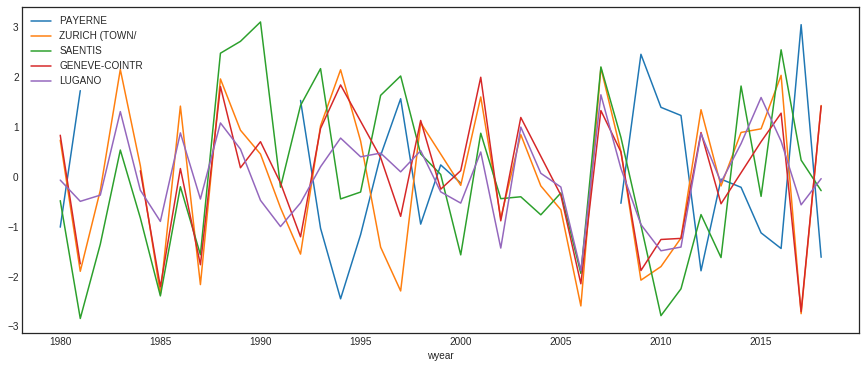

In [70]:
anom_df.plot(x='wyear', figsize=(15,6))